[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ibrahim-ince/BrainTumorClassification/blob/main/44_Classes/F_20.ipynb)

In [ ]:
!pip install tensorflow==2.9.0

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.9.0


In [ ]:
!mkdir data
!unzip "/content/drive/MyDrive/TumorSiniflandirma/archive.zip" -d "/content/data/"

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import cv2
import albumentations as A
import shutil

from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Activation, Add, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.regularizers import l1_l2
from keras.models import Model
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
aug_path = '/content/aug/'

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/valid.csv")
test_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/test.csv")

In [ ]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

AUG

In [ ]:
def get_df(data_path):
        
    image_paths = []
    labels = []
    classes_list = sorted(os.listdir(data_path))
    for image_class in classes_list:
        class_path = os.path.join(data_path, image_class)
        image_list = sorted(os.listdir(class_path))
        for image in image_list:
          image_path = os.path.join(class_path, image)
          image_paths.append(image_path)
          labels.append(image_class)
        
    pd_df = pd.DataFrame({
        'image_path' : image_paths,
        'label' : labels
    })
        
    return pd_df

In [ ]:
def balance(df, n, column, aug_dir):
    
    def get_augmented_image(image, f): # given an image this function returns an augmented image
        if f == 0:
            transform= A.Compose([
                A.HorizontalFlip(always_apply=True),
                A.RandomBrightnessContrast(always_apply=True),
                A.RandomGamma(always_apply=True)])
        else:
            transform= A.Compose([
                A.VerticalFlip(always_apply=True),
                A.HorizontalFlip(always_apply=True),
                A.RandomBrightnessContrast(always_apply=True),
                A.RandomGamma(always_apply=True)])    
        return transform(image=image)['image']

    df=df.copy()
    print('Initial length of dataframe is ', len(df))

    # create folders
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory


    # create and store the augmented images  
    total = 0    
    groups = df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        print(f'augmenting images in train set  for class {label} ', '\r', end='')        
        group = groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count = len(group)   # determine how many samples there are in this class  
        if sample_count < n: # if the class has less than target number of images
            aug_img_count = 0
            delta = n - sample_count  # number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # define where to write the images            
            desc = f'augmenting class {label:25s}'
            for i in range(delta):                
                j = i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path = group['image_path'].iloc[j]
                img = cv2.imread(img_path)
                if aug_img_count < (delta / 2):
                    img = get_augmented_image(img, 0)
                else:
                    img = get_augmented_image(img, 1)
                fname = os.path.basename(img_path)
                fname = 'aug' + str(i) + '-' + fname
                dest_path = os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count += 1
            total += aug_img_count
    print('')
    print('Total Augmented images created= ', total)
    
    # create aug_df and merge with train_df to create composite training set ndf
    aug_df = get_df(aug_dir)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop = True)
    print('Length of augmented dataframe is now ', len(df))
    
    return df

In [ ]:
train_counts = list(train_df['label'].value_counts())

In [ ]:
max_sample = max(train_counts)

In [ ]:
train_df = balance(train_df, max_sample, 'label', aug_path)

Initial length of dataframe is  3135

Total Augmented images created=  8217
Length of augmented dataframe is now  11352


In [ ]:
print(f"Eğitim kümesinde {len(train_df)} adet görüntü var.")

Eğitim kümesinde 11352 adet görüntü var.


In [ ]:
train_df['label'].value_counts()

Meningioma T1C+           258
Meningioma T1             258
Meduloblastoma T2         258
Granuloma T2              258
Germinoma T2              258
Oligodendroglioma T2      258
Neurocitoma T2            258
Ependimoma T1             258
Meduloblastoma T1C+       258
Ependimoma T1C+           258
Glioblastoma T1C+         258
_NORMAL T1                258
Glioblastoma T2           258
Papiloma T1C+             258
Neurocitoma T1            258
Oligodendroglioma T1C+    258
Tuberculoma T1            258
Ganglioglioma T1          258
Germinoma T1C+            258
Ganglioglioma T1C+        258
Granuloma T1C+            258
Astrocitoma T2            258
Neurocitoma T1C+          258
Schwannoma T1C+           258
Granuloma T1              258
Glioblastoma T1           258
Astrocitoma T1            258
Papiloma T2               258
Tuberculoma T1C+          258
Ependimoma T2             258
Oligodendroglioma T1      258
Germinoma T1              258
Tuberculoma T2            258
Carcinoma 

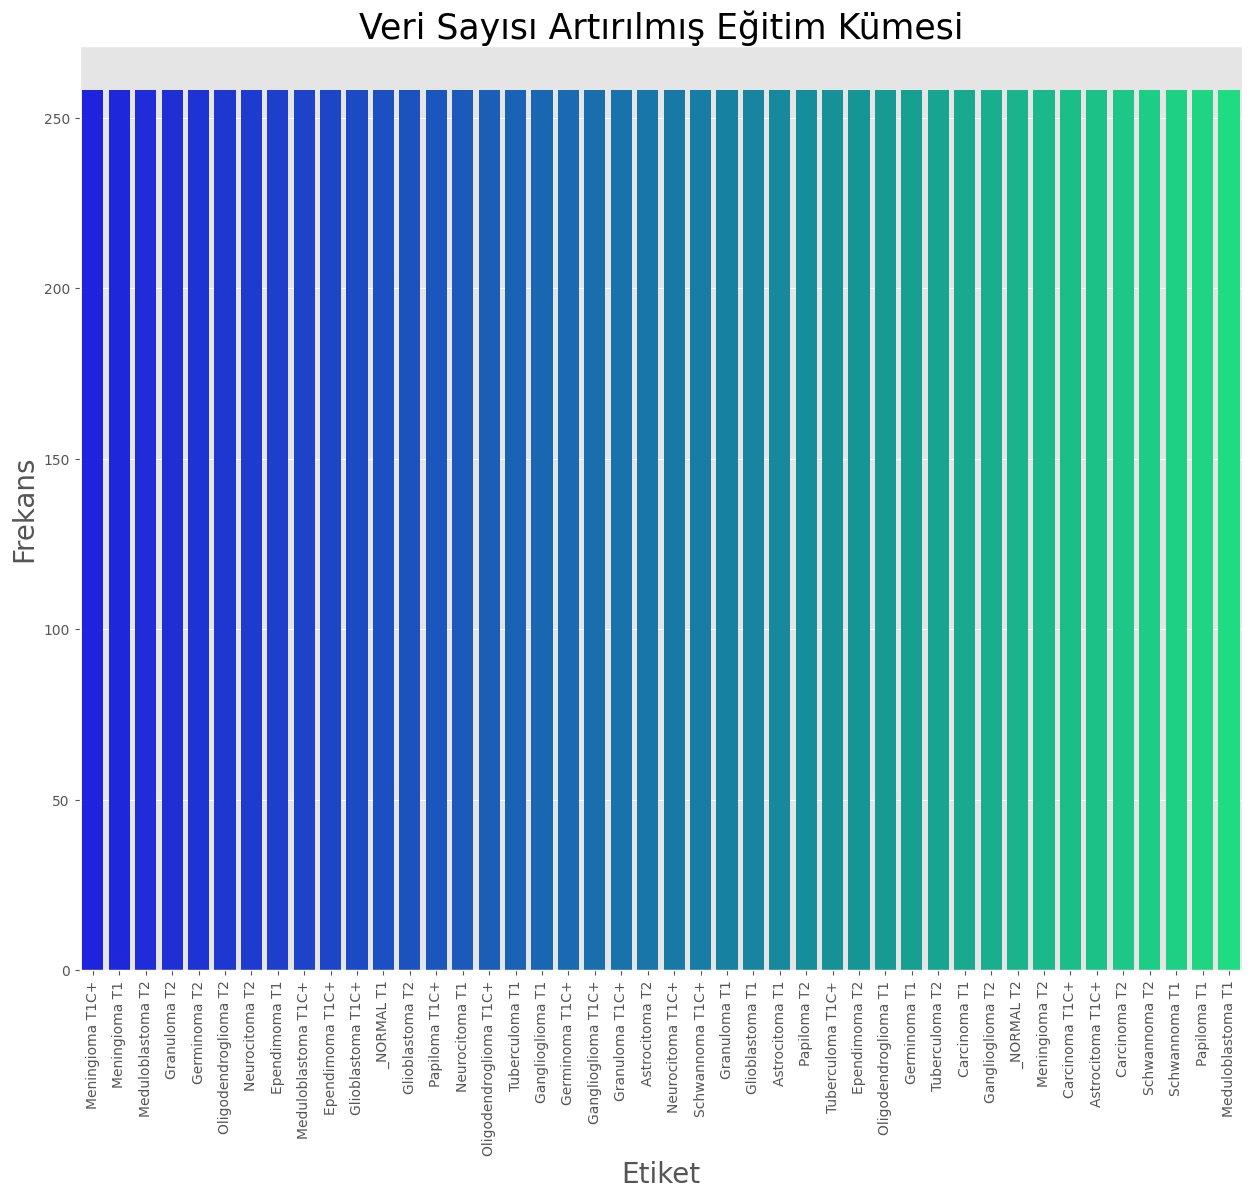

In [ ]:
x = train_df['label']
order = x.value_counts().index
count_plot(x, "Veri Sayısı Artırılmış Eğitim Kümesi", "Etiket", 'Frekans', 15,12, rotation = True, order=order)

AUG

In [ ]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16

test_length = len(test_df)
test_batch_size = sorted([int(test_length / n) for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80], reverse=True)[0]  
test_steps = int(test_length / test_batch_size)   

In [ ]:
train_gen = ImageDataGenerator()

test_gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(train_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= True, 
                                    batch_size= batch_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= False, 
                                    batch_size= batch_size)

test_gen = test_gen.flow_from_dataframe(test_df, 
                                   x_col= 'image_path', 
                                   y_col= 'label', 
                                   target_size= img_size, 
                                   class_mode= 'categorical',
                                   color_mode= color, 
                                   shuffle= False, 
                                   batch_size= test_batch_size)

Found 11351 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen) # get a sample batch from the generator 
    plt.figure(figsize = (25, 25))
    length = len(labels)
    if length < 25:   #show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

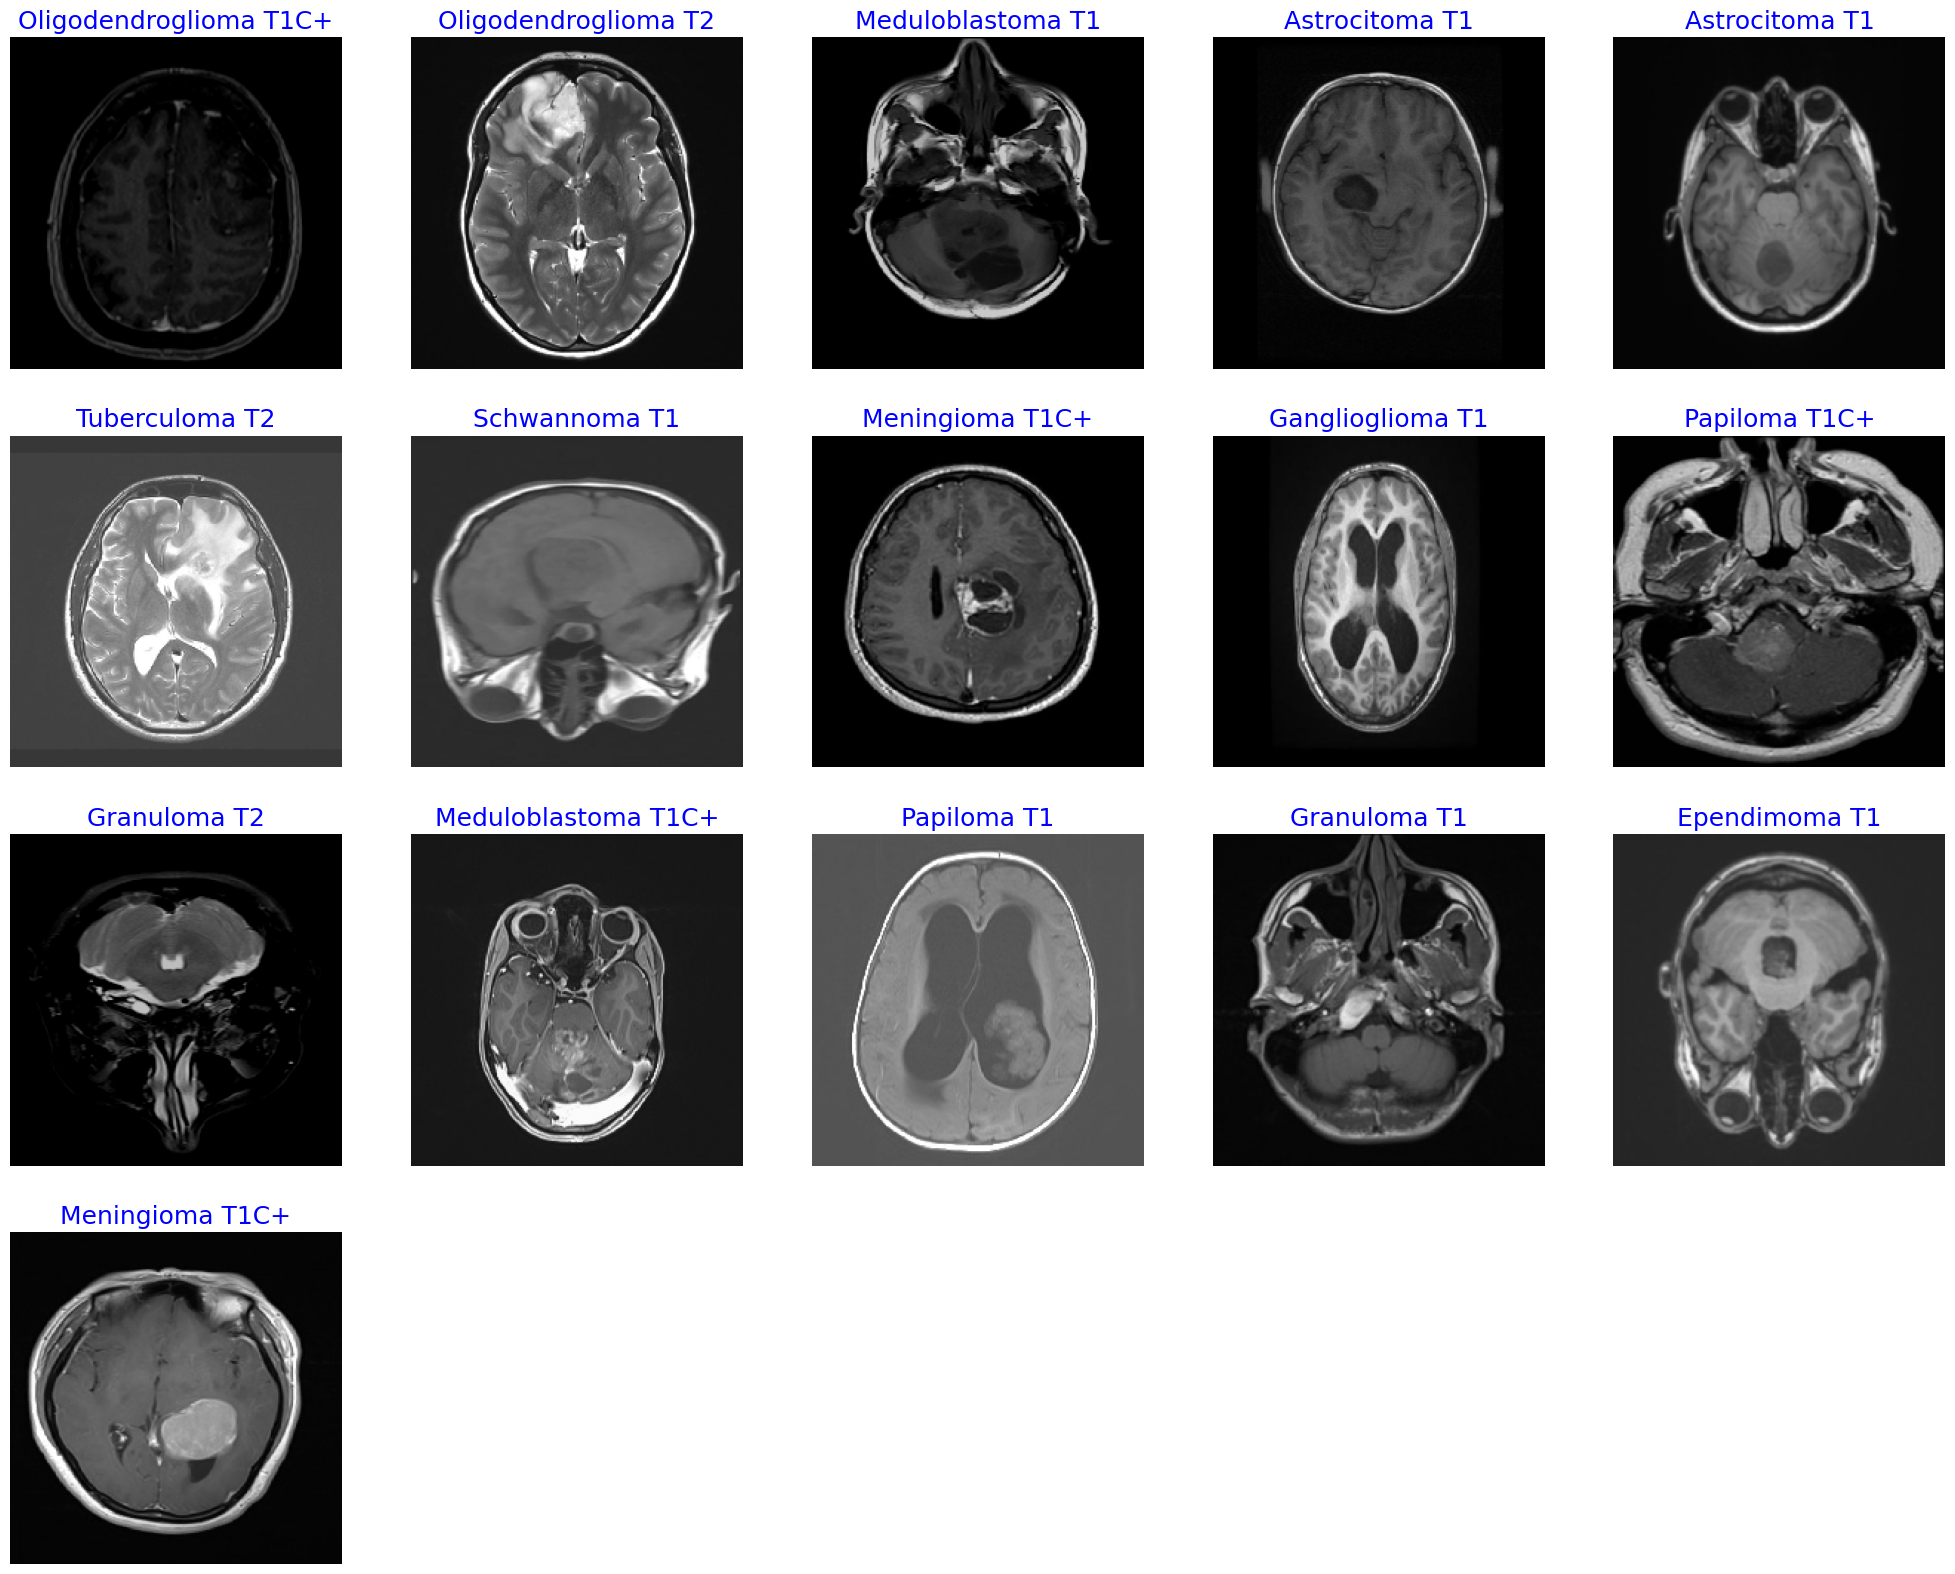

In [ ]:
show_image_samples(train_gen)

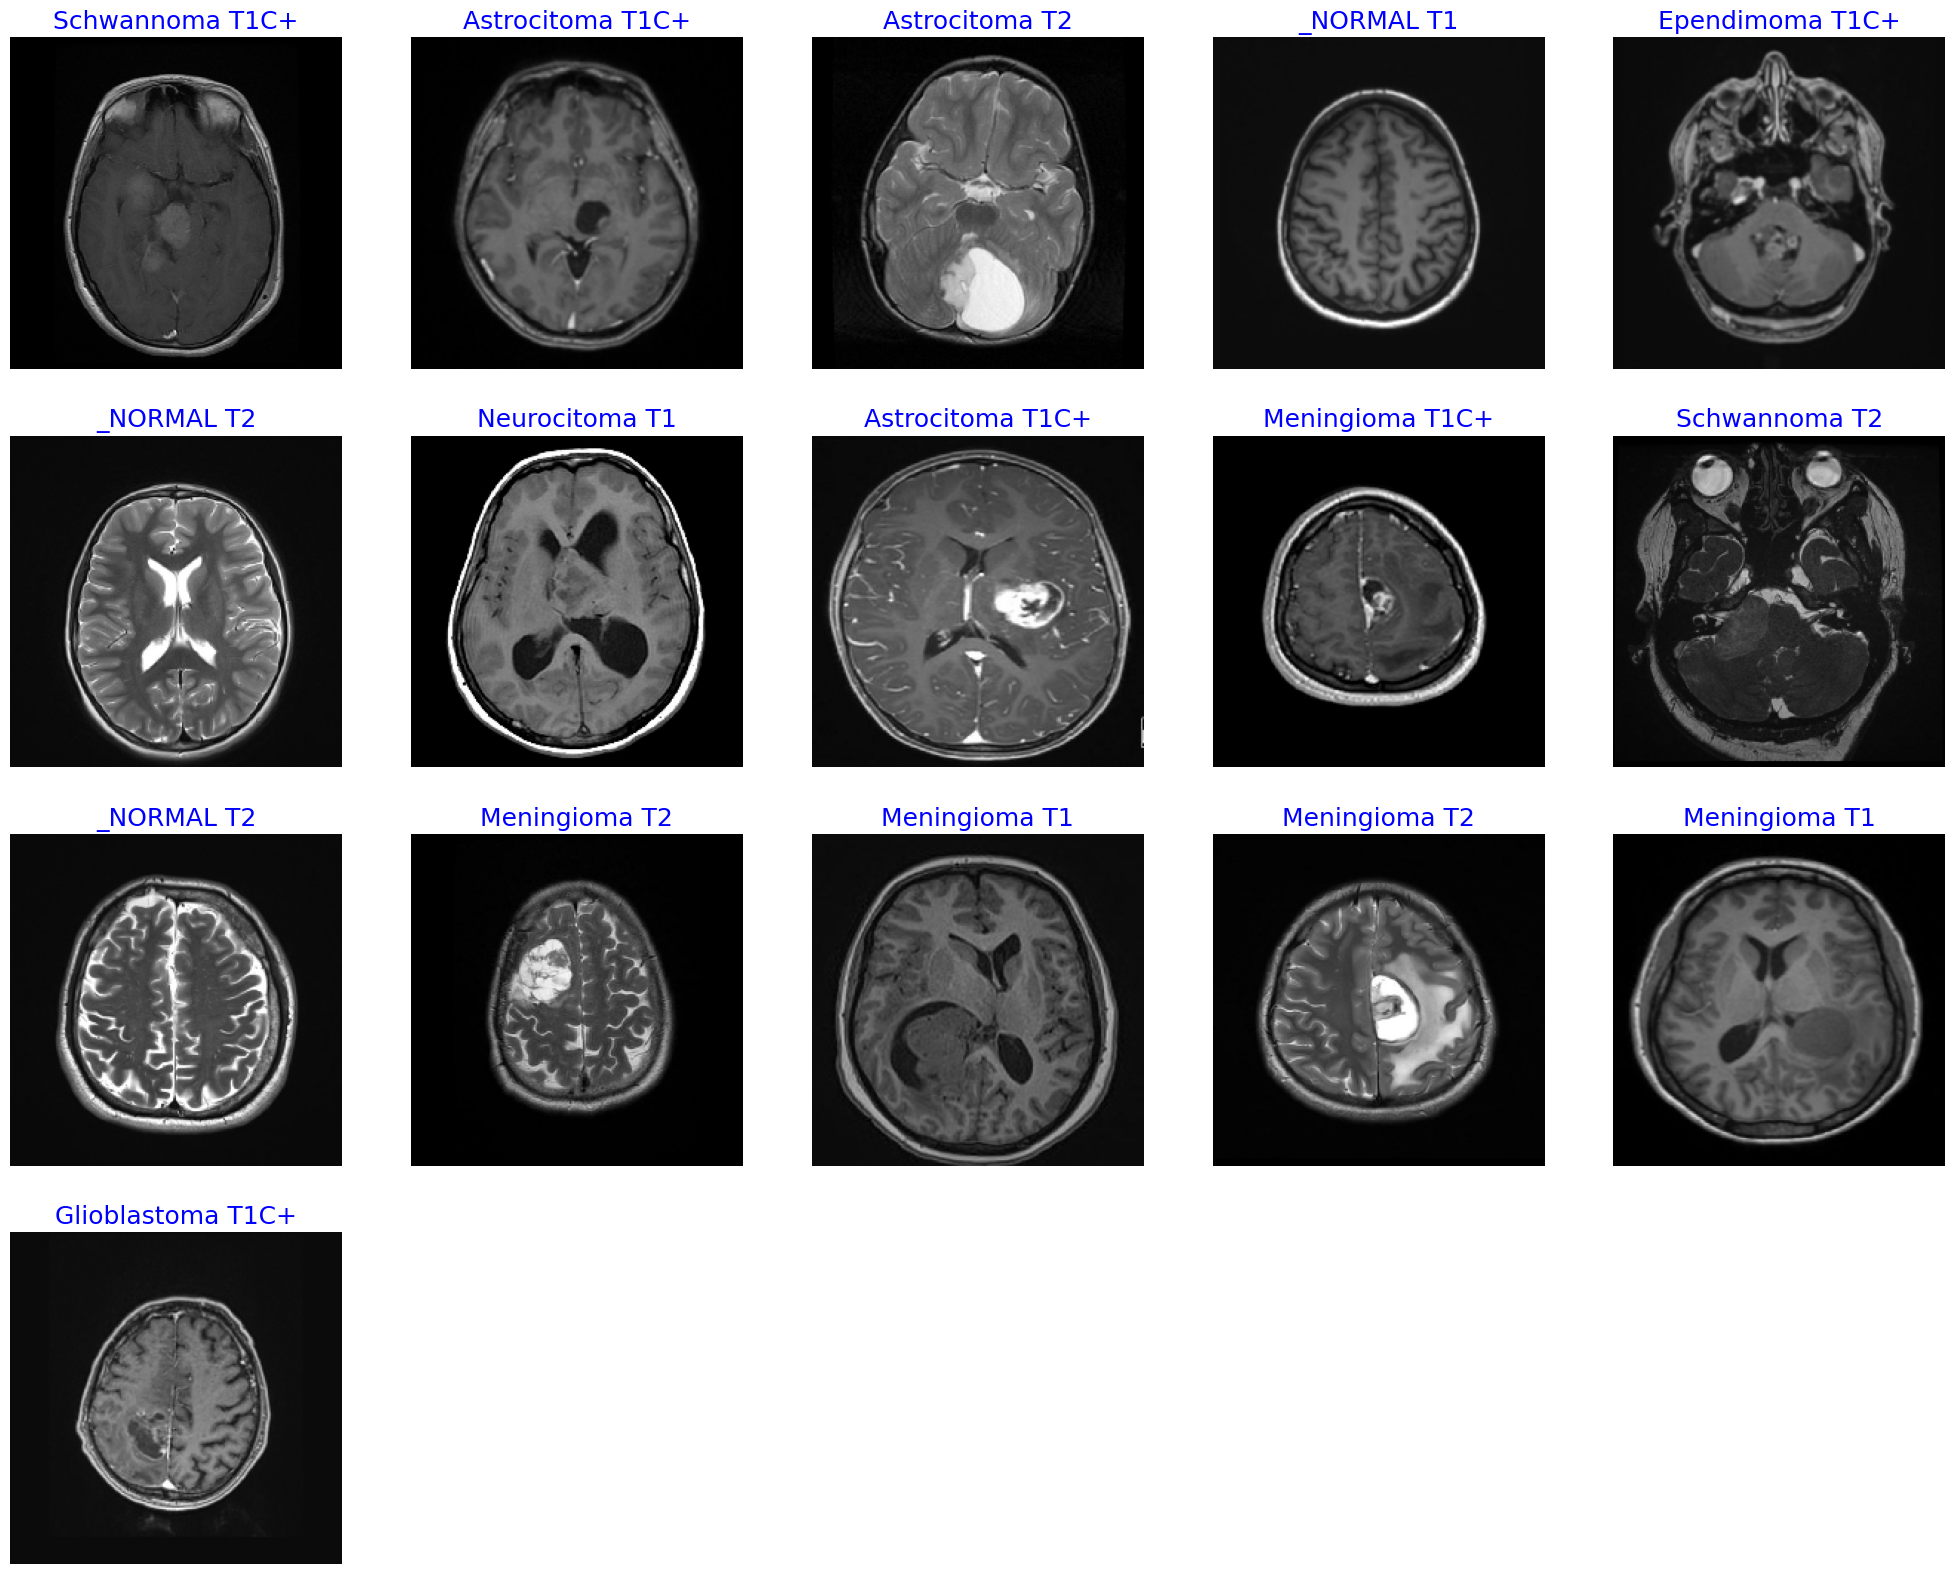

In [ ]:
show_image_samples(valid_gen)

In [ ]:
show_image_samples(test_gen)

In [ ]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# this is the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return

def predictor(model,test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

def print_errors(error_list,error_pred_list, delimiter):
    if len(error_list) == 0:
        print('There were no errors in predicting the test set')
    else:
        if len(error_list)>500:
            print('There were over 50 misclassifications, the error list will not be printed')
        else:
            print('Below is a list of test files that were miss classified \n')
            print('{0:^50s}{1:^50s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)                 
                slength=len(split)
                f=split[slength-2]   
                print(f'{f:^50s}{error_pred_list[i]:^50s}')

def plot_errors_vs_class(error_list, delimiter):
    if len(error_list)==0:
        return 
    error_classes=[]
    for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)
                slength=len(split)                
                klass= split[slength-2]                
                if klass not in error_classes:
                    error_classes.append(klass)   
    error_classes=sorted(error_classes, reverse=True)    
    error_count= [0 for i in range(len(error_classes))]
    for  i in range (len(error_classes)):
        eklass=error_classes[i]    
        for fpath in error_list:
            split=fpath.split(delimiter)
            slength=len(split)
            fklass= split[slength-2] 
            if eklass == fklass:
                error_count[i] +=1
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_count)
    plt.title( ' Classification Errors on Test Set by Class')
    plt.show()
    return error_classes, error_count

def print_error_rate(error_classes, error_count, test_df):
    value_counts = []
    for i in range(len(error_classes)):
         value_counts.append((test_df['label'].values == error_classes[i]).sum())
    error_rates = [0 for i in range(len(error_classes))]
    for i in range(len(error_classes)):
        error_rates[i] = (error_count[i] / value_counts[i]) * 100
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_rates)
    plt.title( ' Classification Error Rates on Test Set by Class')
    plt.show()

In [ ]:
class_count = len(list(train_gen.class_indices.keys()))

In [ ]:
def create_vgg(input_shape, num_classes):
    """
    Creates a custom VGG model from scratch.
    
    :param input_shape: Tuple specifying the shape of the input images.
    :param num_classes: Number of output classes.
    :return: Keras VGG model.
    """

    input_layer = Input(shape=input_shape)

    # Convolution and maxpool layers for feature extraction
    # Introduce regularization (L1, L2, or both) to the convolutional and dense layers to prevent overfitting
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(input_layer)
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)

    conv3 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    conv4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)

    conv5 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    conv6 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv5)
    conv7 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv6)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv7)

    # Flatten output
    flat = Flatten()(pool3)

    # Dense layers
    dense1 = Dense(256, activation='relu')(flat)
    dropout1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
model = create_vgg(img_shape, class_count)

model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                             

In [ ]:
save_path = "/content/drive/MyDrive/TumorSiniflandirma/final_models/F_20.h5"

In [ ]:
checkpoint = ModelCheckpoint(save_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min', 
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              mode='auto',
                              min_lr=0.0001,
                              verbose= 1)

history = model.fit(x= train_gen, 
                    epochs= 100, batch_size= 16,
                    callbacks=[early_stop, checkpoint, reduce_lr],
                    validation_data= valid_gen)

Epoch 1/100
710/710 [==============================] - ETA: 0s - loss: 4.1501 - accuracy: 0.0499 - F1_score: 0.0089 - auc: 0.5863
Epoch 1: val_loss improved from inf to 3.47718, saving model to /content/drive/MyDrive/TumorSiniflandirma/final_models/F_20.h5
710/710 [==============================] - 105s 133ms/step - loss: 4.1501 - accuracy: 0.0499 - F1_score: 0.0089 - auc: 0.5863 - val_loss: 3.4772 - val_accuracy: 0.1696 - val_F1_score: 0.0218 - val_auc: 0.8061 - lr: 0.0010
Epoch 2/100
710/710 [==============================] - ETA: 0s - loss: 2.7340 - accuracy: 0.3222 - F1_score: 0.2480 - auc: 0.8752
Epoch 2: val_loss improved from 3.47718 to 2.38773, saving model to /content/drive/MyDrive/TumorSiniflandirma/final_models/F_20.h5
710/710 [==============================] - 97s 136ms/step - loss: 2.7340 - accuracy: 0.3222 - F1_score: 0.2480 - auc: 0.8752 - val_loss: 2.3877 - val_accuracy: 0.4271 - val_F1_score: 0.2343 - val_auc: 0.9324 - lr: 0.0010
Epoch 3/100
710/710 [==================

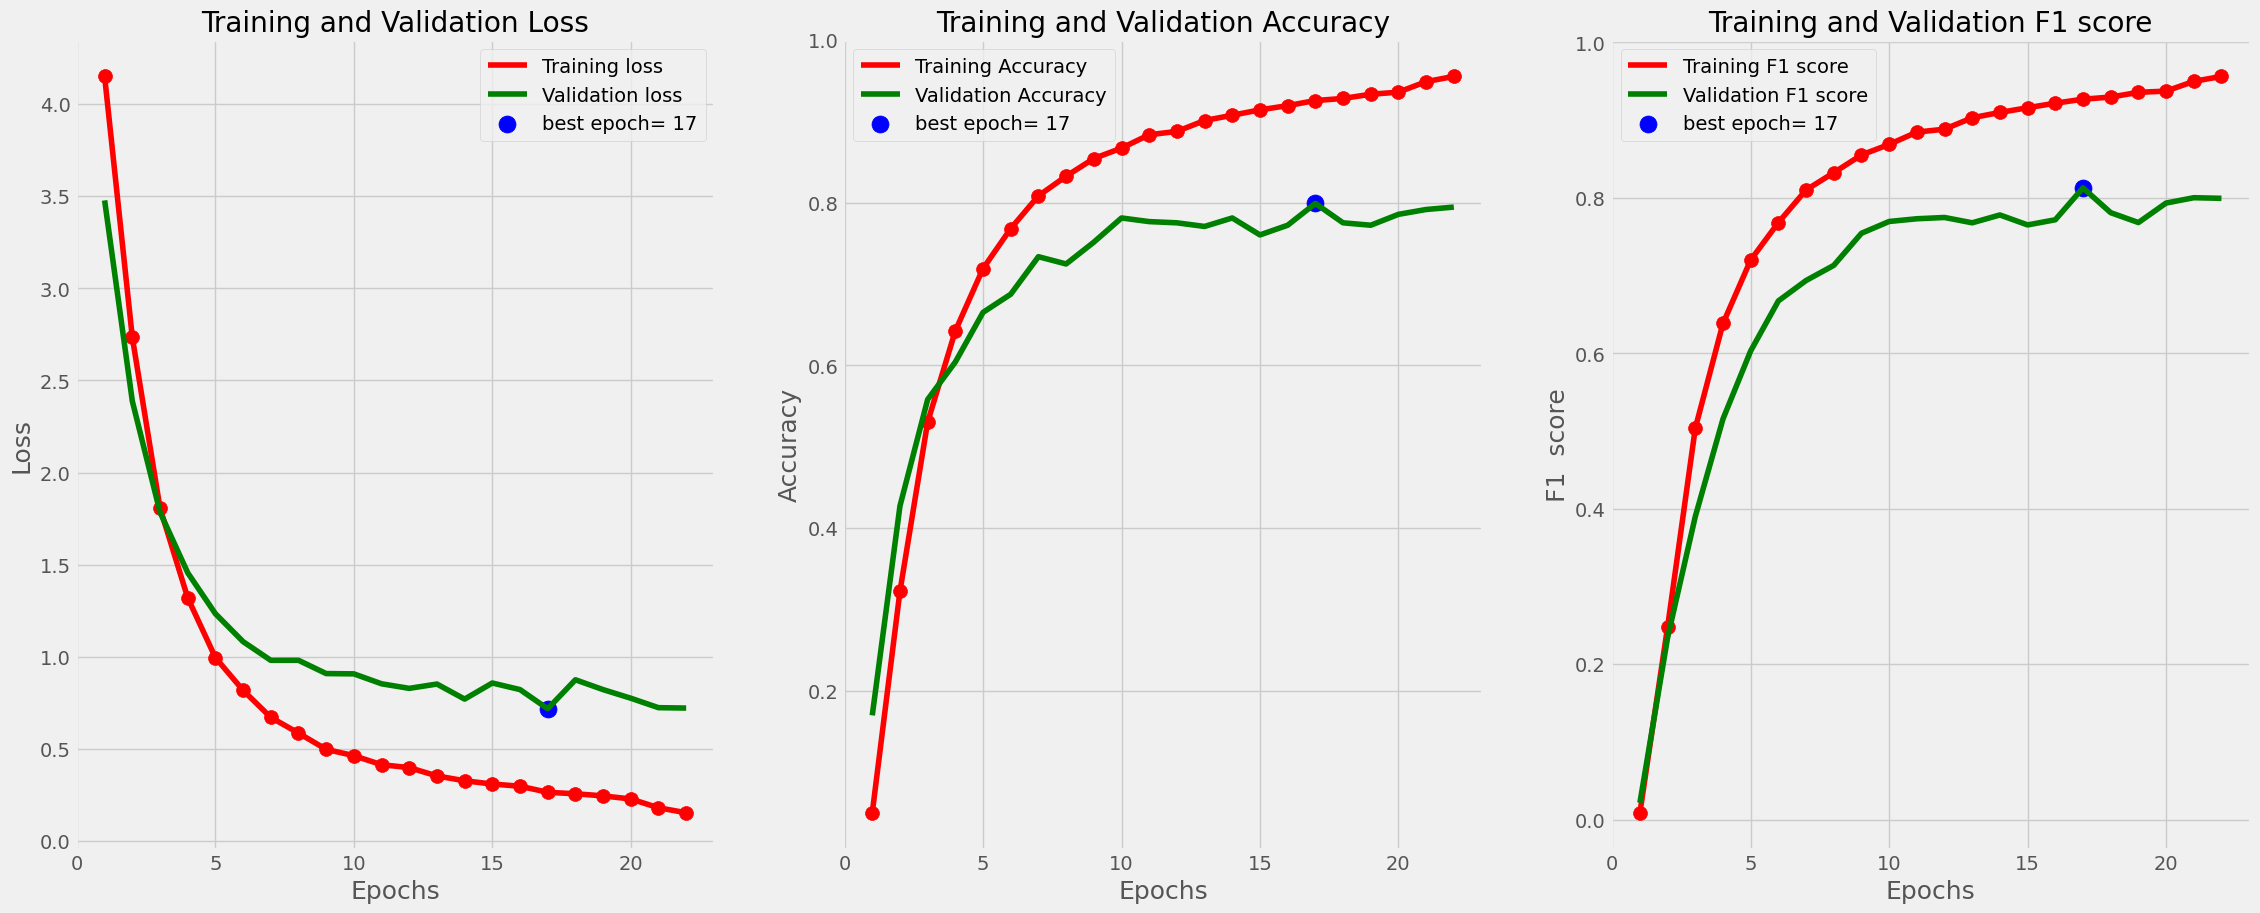

In [ ]:
tr_plot(history)

In [ ]:
best_model = tf.keras.models.load_model(save_path, custom_objects={"F1_score": F1_score})

In [ ]:
train_score = best_model.evaluate(train_gen, verbose= 1)
valid_score = best_model.evaluate(valid_gen, verbose= 1)
test_score = best_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 5s 253ms/step - loss: 0.9431 - accuracy: 0.7604 - F1_score: 0.7720 - auc: 0.9744
Train Loss:  0.028922030702233315
Train Accuracy:  0.9990309476852417
Train F1-score:  0.9988442063331604
--------------------
Validation Loss:  0.7176909446716309
Validation Accuracy:  0.7991071343421936
Validation F1-score:  0.8127856254577637
--------------------
Test Loss:  0.9431031346321106
Test Accuracy:  0.7604166865348816
Test F1-score:  0.7719902396202087


12/12 [==============================] - 3s 272ms/step
there were 161 errors in 672 tests for an accuracy of  76.04


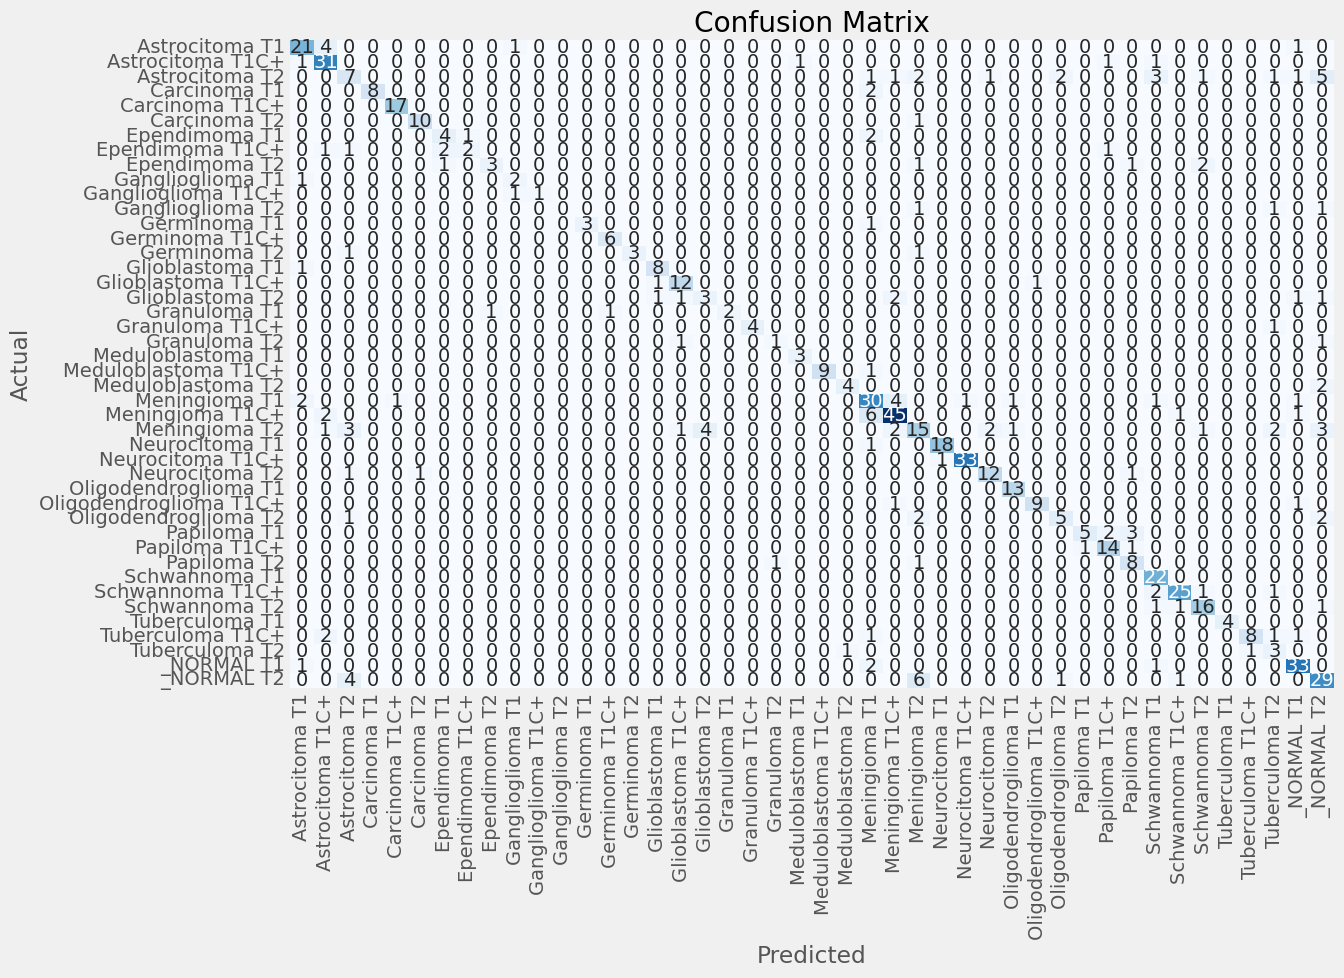

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
                         precision    recall  f1-score   support

        Astrocitoma T1     0.7778    0.7778    0.7778        27
      Astrocitoma T1C+     0.7561    0.8857    0.8158        35
        Astrocitoma T2     0.3889    0.2800    0.3256        25
          Carcinoma T1     1.0000    0.8000    0.8889        10
        Carcinoma T1C+     0.9444    1.0000    0.9714        17
          Carcinoma T2     0.9091    0.9091    0.9091        11
         Ependimoma T1     0.5714    0.5714    0.5714         7
       Ependimoma T1C+     0.6667    0.2857    0.4000         7
         Ependimoma T2     0.7500    0.3750    0.5000         8
      Ganglioglioma T1     0.5000    0.6667    0.5714         3
    Ganglioglioma T1C+     1.0000    0.5000    0.6667         2
      Ganglioglioma T2     0.0000    0.0000    0.0000         3
          Germinoma T1     1.0000    0.7500    0.8571         4
        Germinoma T1C+     0.8571    1.0000    0.9231   

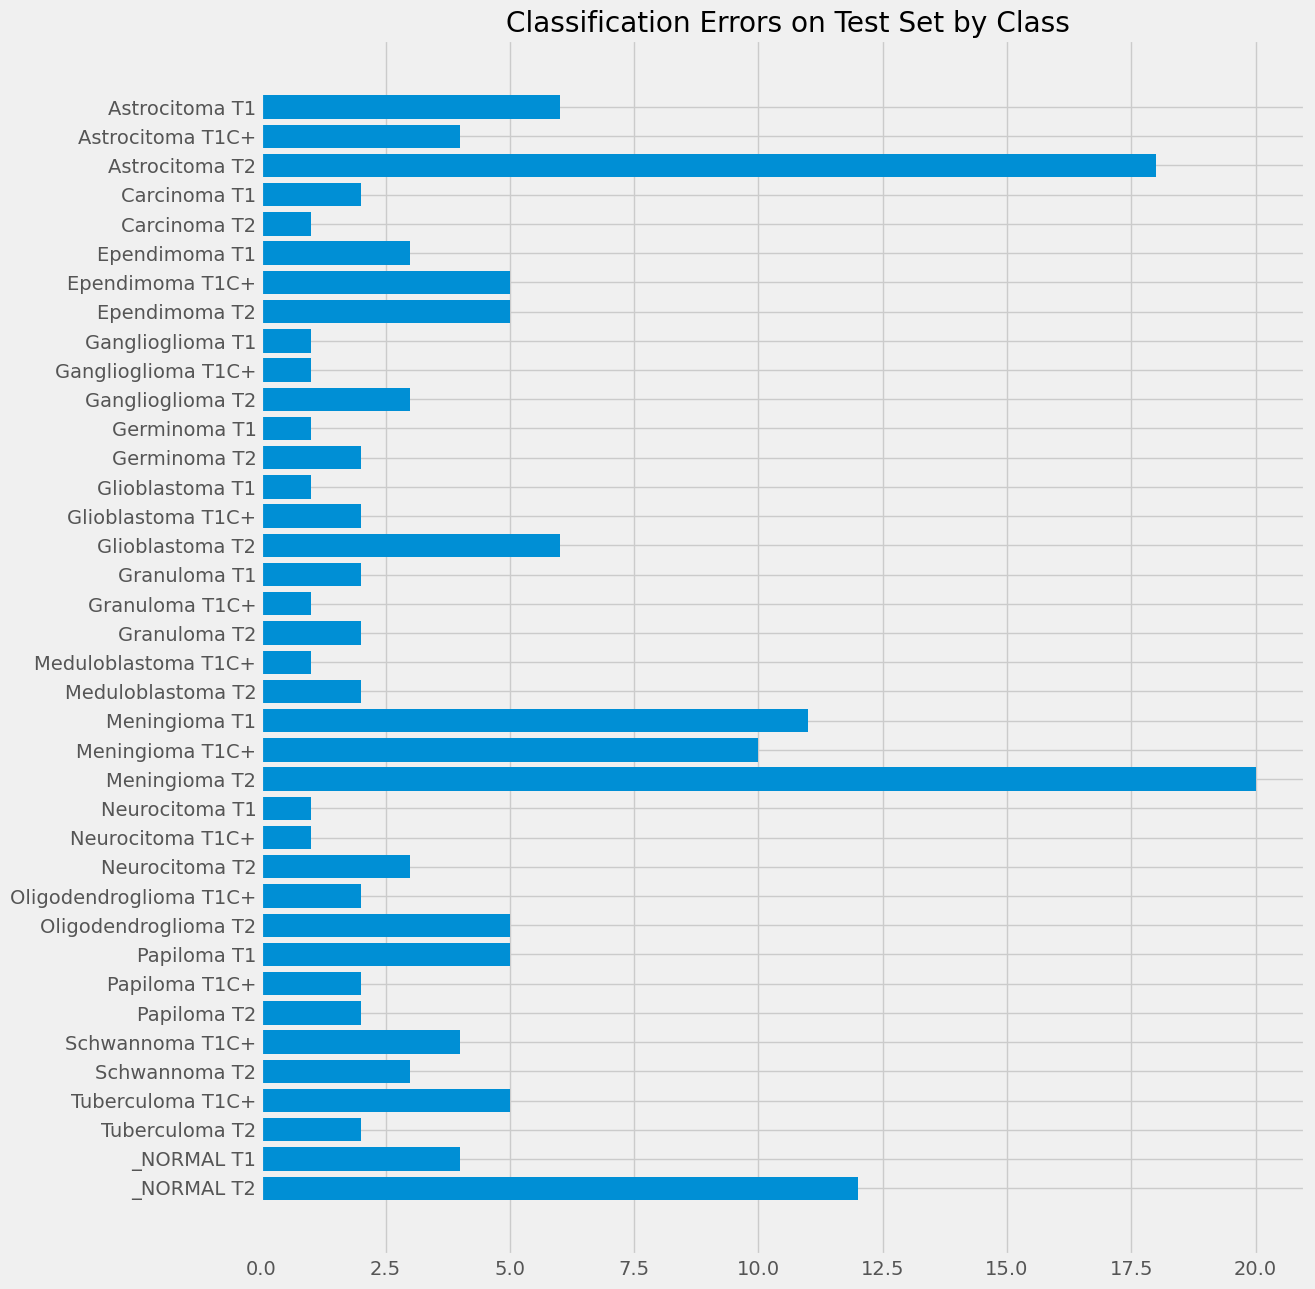

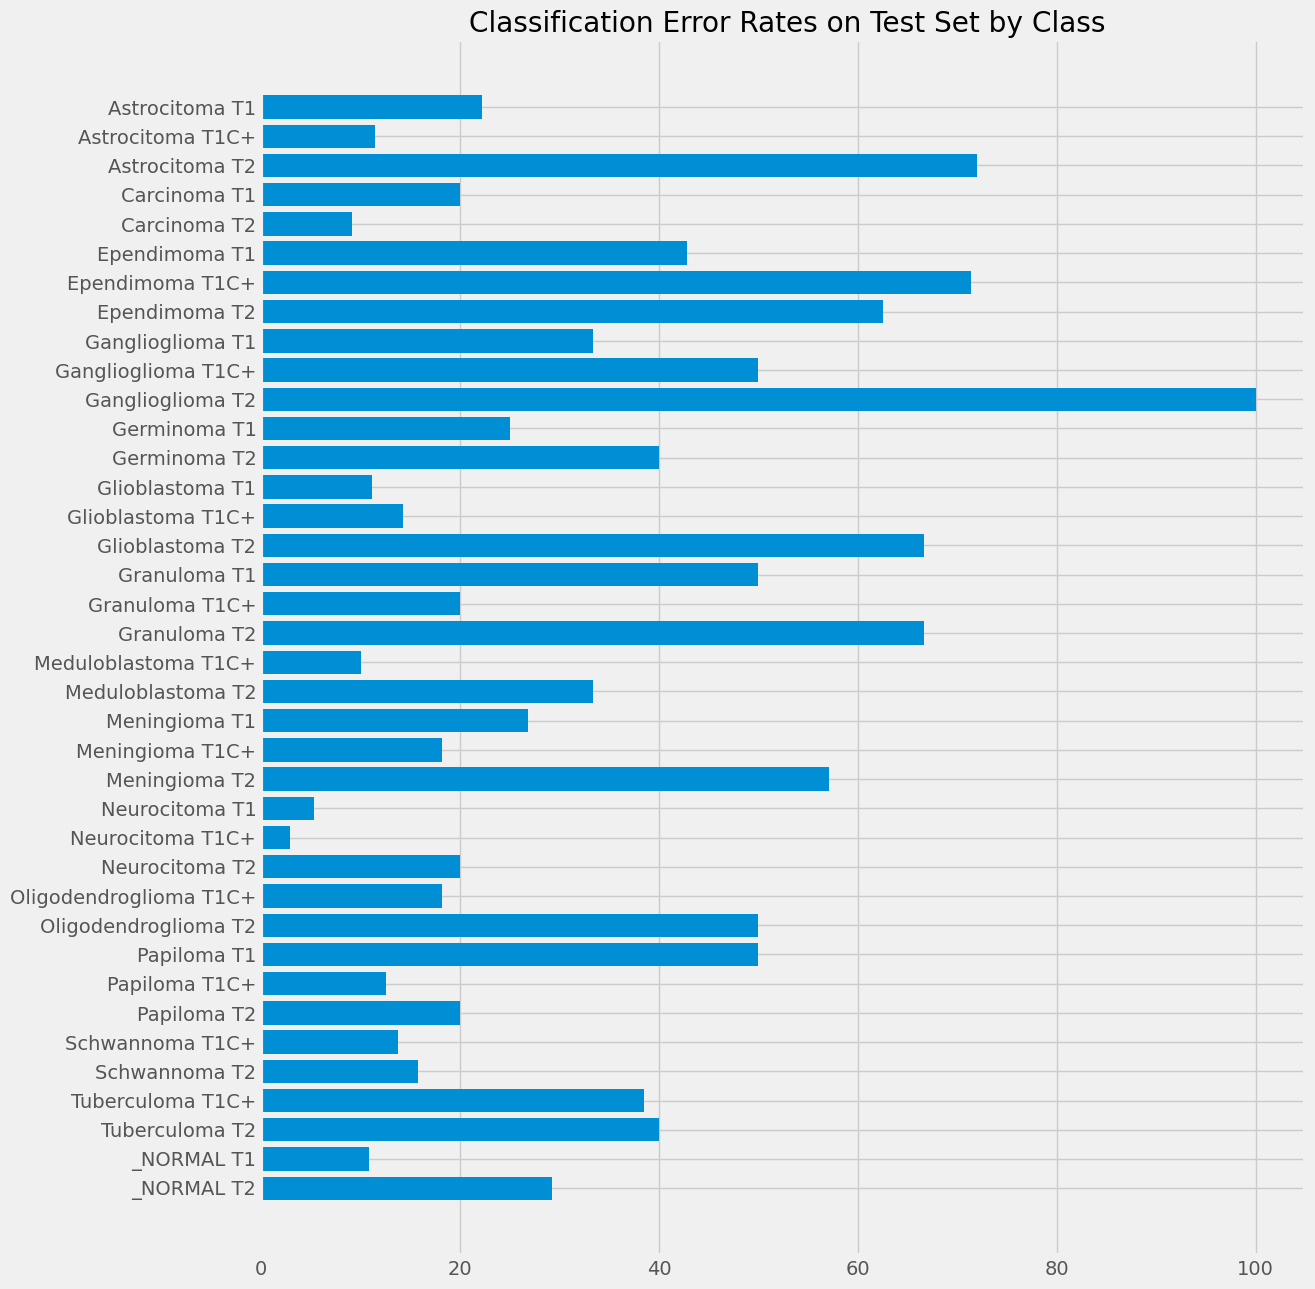

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(best_model, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)